# 3. Разведывательный анализ данных

Продолжаем исследование наших данных. На данном этапе мы попробуем отыскать закономерности, которые больше всего влияют на финальную стоимость недвижимости, а также проверим некоторые из сформулированных ранее гипотез. После этого мы произведем подготовку данных к построению модели, перекодировав имеющиеся признаки.  

Импортируем библиотеки, которые нам для этого понадобятся:

In [1]:
import numpy as np
import pandas as pd

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.io as pio
pio.renderers.default='png'
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection

Прочитаем очищенные данные, с которыми мы работали на предыдущих двух этапах: 

In [2]:
data = pd.read_csv("data/realty_data.csv")
print('Data shape: {}'.format(data.shape))
data.head()

Data shape: (271765, 20)


status           type  zipcode state            city    sqft  stories  \
0  contingent  single-family  28387.0    NC  Southern Pines  2900.0      1.0   
1    for sale  single-family  99216.0    WA  Spokane Valley  1947.0      2.0   
2    for sale  single-family  90049.0    CA     Los Angeles  3000.0      1.0   
3  contingent          other  34759.0    FL       Poinciana  1507.0      1.0   
4  contingent  single-family  50401.0    IA      Mason City  3588.0      1.0   

   baths  beds heating parking  is_garage pool  acres  avg_rating_school  \
0    3.0   4.0     yes     yes      False   no   0.00                5.2   
1    3.0   3.0      no     yes      False   no   0.13                4.0   
2    2.0   3.0     yes     yes       True  yes   0.20                6.7   
3    2.0   3.0     yes     yes      False   no   0.11                2.3   
4    2.0   3.0     yes     yes      False   no   2.86                3.8   

   avg_distance_school  has_pk   built remodeled     target  
0                 5.54       1  2019.0        no   418000.0  
1                 1.33       1  2019.0        no   310000.0  
2                 1.96       0  1961.0       yes  2895000.0  
3                 3.83       1  2006.0       yes   181500.0  
4                 6.35       1  1970.0        no   244900.0

Давайте вспомним, с какими признаками мы имеем дело:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271765 entries, 0 to 271764
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               271765 non-null  object 
 1   type                 271765 non-null  object 
 2   zipcode              271765 non-null  float64
 3   state                271765 non-null  object 
 4   city                 271765 non-null  object 
 5   sqft                 271765 non-null  float64
 6   stories              271765 non-null  float64
 7   baths                271765 non-null  float64
 8   beds                 271765 non-null  float64
 9   heating              271765 non-null  object 
 10  parking              271765 non-null  object 
 11  is_garage            271765 non-null  bool   
 12  pool                 271765 non-null  object 
 13  acres                271765 non-null  float64
 14  avg_rating_school    271765 non-null  float64
 15  avg_distance_scho

Наши объекты недвижимости характеризуются следующими признаками:  

**Описание объекта недвижимости**  

`status` — текущий статус объекта на продажу;  
`type` — тип объекта недвижимости;  
`sqft` — площадь объекта в квадратных футах;  
`stories` — количество этажей;  
`baths` — количество ванных комнат;  
`beds` — количество спален;   
`pool` - наличие бассейна;  
`acres` - размер участка земли как приложение к дому;  
`built` - год постройки объекта;  
`remodeled` - факт обновления объекта (реставрация, плановый ремонт).
  
**Благоустройство**  

`heating` - факт подключения объекта к системе отопления;   
`parking` - наличие парковки;  
`is_garage` - наличие гаража;  

**Привлекательность района**

`avg_rating_school` - средний рейтинг близлежащих школ (по 10-бальной школе);  
`avg_distance_school` - среднее расстояние до школы;  
`has_pk` - имеются ли подготовительные курсы к школе (для поступающих детей - дошколят)

**Географическая информация**  
   
`state` — штат;  
`city` - город или район расположения объекта;  
`zipcode` - почтовый индекс

**Целевой фактор**
  
`target` — цена объекта недвижимости (его и будем прогнозировать).

In [4]:
data.describe()

zipcode           sqft        stories          baths  \
count  271765.000000  271765.000000  271765.000000  271765.000000   
mean    53062.547944    1930.030600       1.654198       2.406487   
std     26610.632253     853.743361       2.345178       0.867778   
min      1104.000000      72.000000       1.000000       0.000000   
25%     33062.000000    1274.000000       1.000000       2.000000   
50%     37377.000000    1778.000000       1.000000       2.000000   
75%     78045.000000    2440.000000       2.000000       3.000000   
max    331446.000000    4500.000000      96.000000       7.000000   

                beds          acres  avg_rating_school  avg_distance_school  \
count  271765.000000  271765.000000      271765.000000        271765.000000   
mean        3.174390       0.204752           5.135962             2.697997   
std         0.917078       0.392983           1.908339             2.774823   
min         0.000000       0.000000           1.000000             0.020000   
25%         3.000000       0.000000           3.700000             1.040000   
50%         3.000000       0.130000           5.000000             1.710000   
75%         4.000000       0.220000           6.500000             3.060000   
max         8.000000       4.460000          10.000000            16.560000   

              has_pk          built        target  
count  271765.000000  271765.000000  2.717650e+05  
mean        0.771118    1983.544014  4.714844e+05  
std         0.420114      31.639153  6.852514e+05  
min         0.000000    1900.000000  8.900000e+03  
25%         1.000000    1960.000000  2.099000e+05  
50%         1.000000    1990.000000  3.200000e+05  
75%         1.000000    2012.000000  5.199000e+05  
max         1.000000    2022.000000  5.000000e+07

In [5]:
data.describe(include='object')

status           type   state     city heating parking    pool  \
count     271765         271765  271765   271765  271765  271765  271765   
unique         6              8      35     1551       2       2       2   
top     for sale  single-family      FL  Houston     yes     yes      no   
freq      183394         172873   84232    18609  209117  270902  238234   

       remodeled  
count     271765  
unique         2  
top           no  
freq      149689

Описательная статистика выведена, однако целевая переменная представлена в экспоненциальной форме из-за смещения в сторону больших значений:

In [6]:
print(f"Минимальная стоимость недвижимости: ${float(data['target'].min())}")
print(f"Максимальная стоимость недвижимости: ${float(data['target'].max()):,.0f}")

Минимальная стоимость недвижимости: $8900.0
Максимальная стоимость недвижимости: $50,000,000


Кроме того, в данных присутствуют булевы признаки, что мешает нам провести качественную оценку взаимосвязей, поэтому давайте приведем все в единый формат:

In [7]:
# словари для замены значений в признаках
cat_garage = {False: 'no', True: 'yes'}
cat_pk = {0: 'no', 1: 'yes'}

data['is_garage'] = data['is_garage'].map(cat_garage)
data['has_pk'] = data['has_pk'].map(cat_pk)

Построим `pairplot` для оценки распределения и анализа взаимосвязей между признаками:

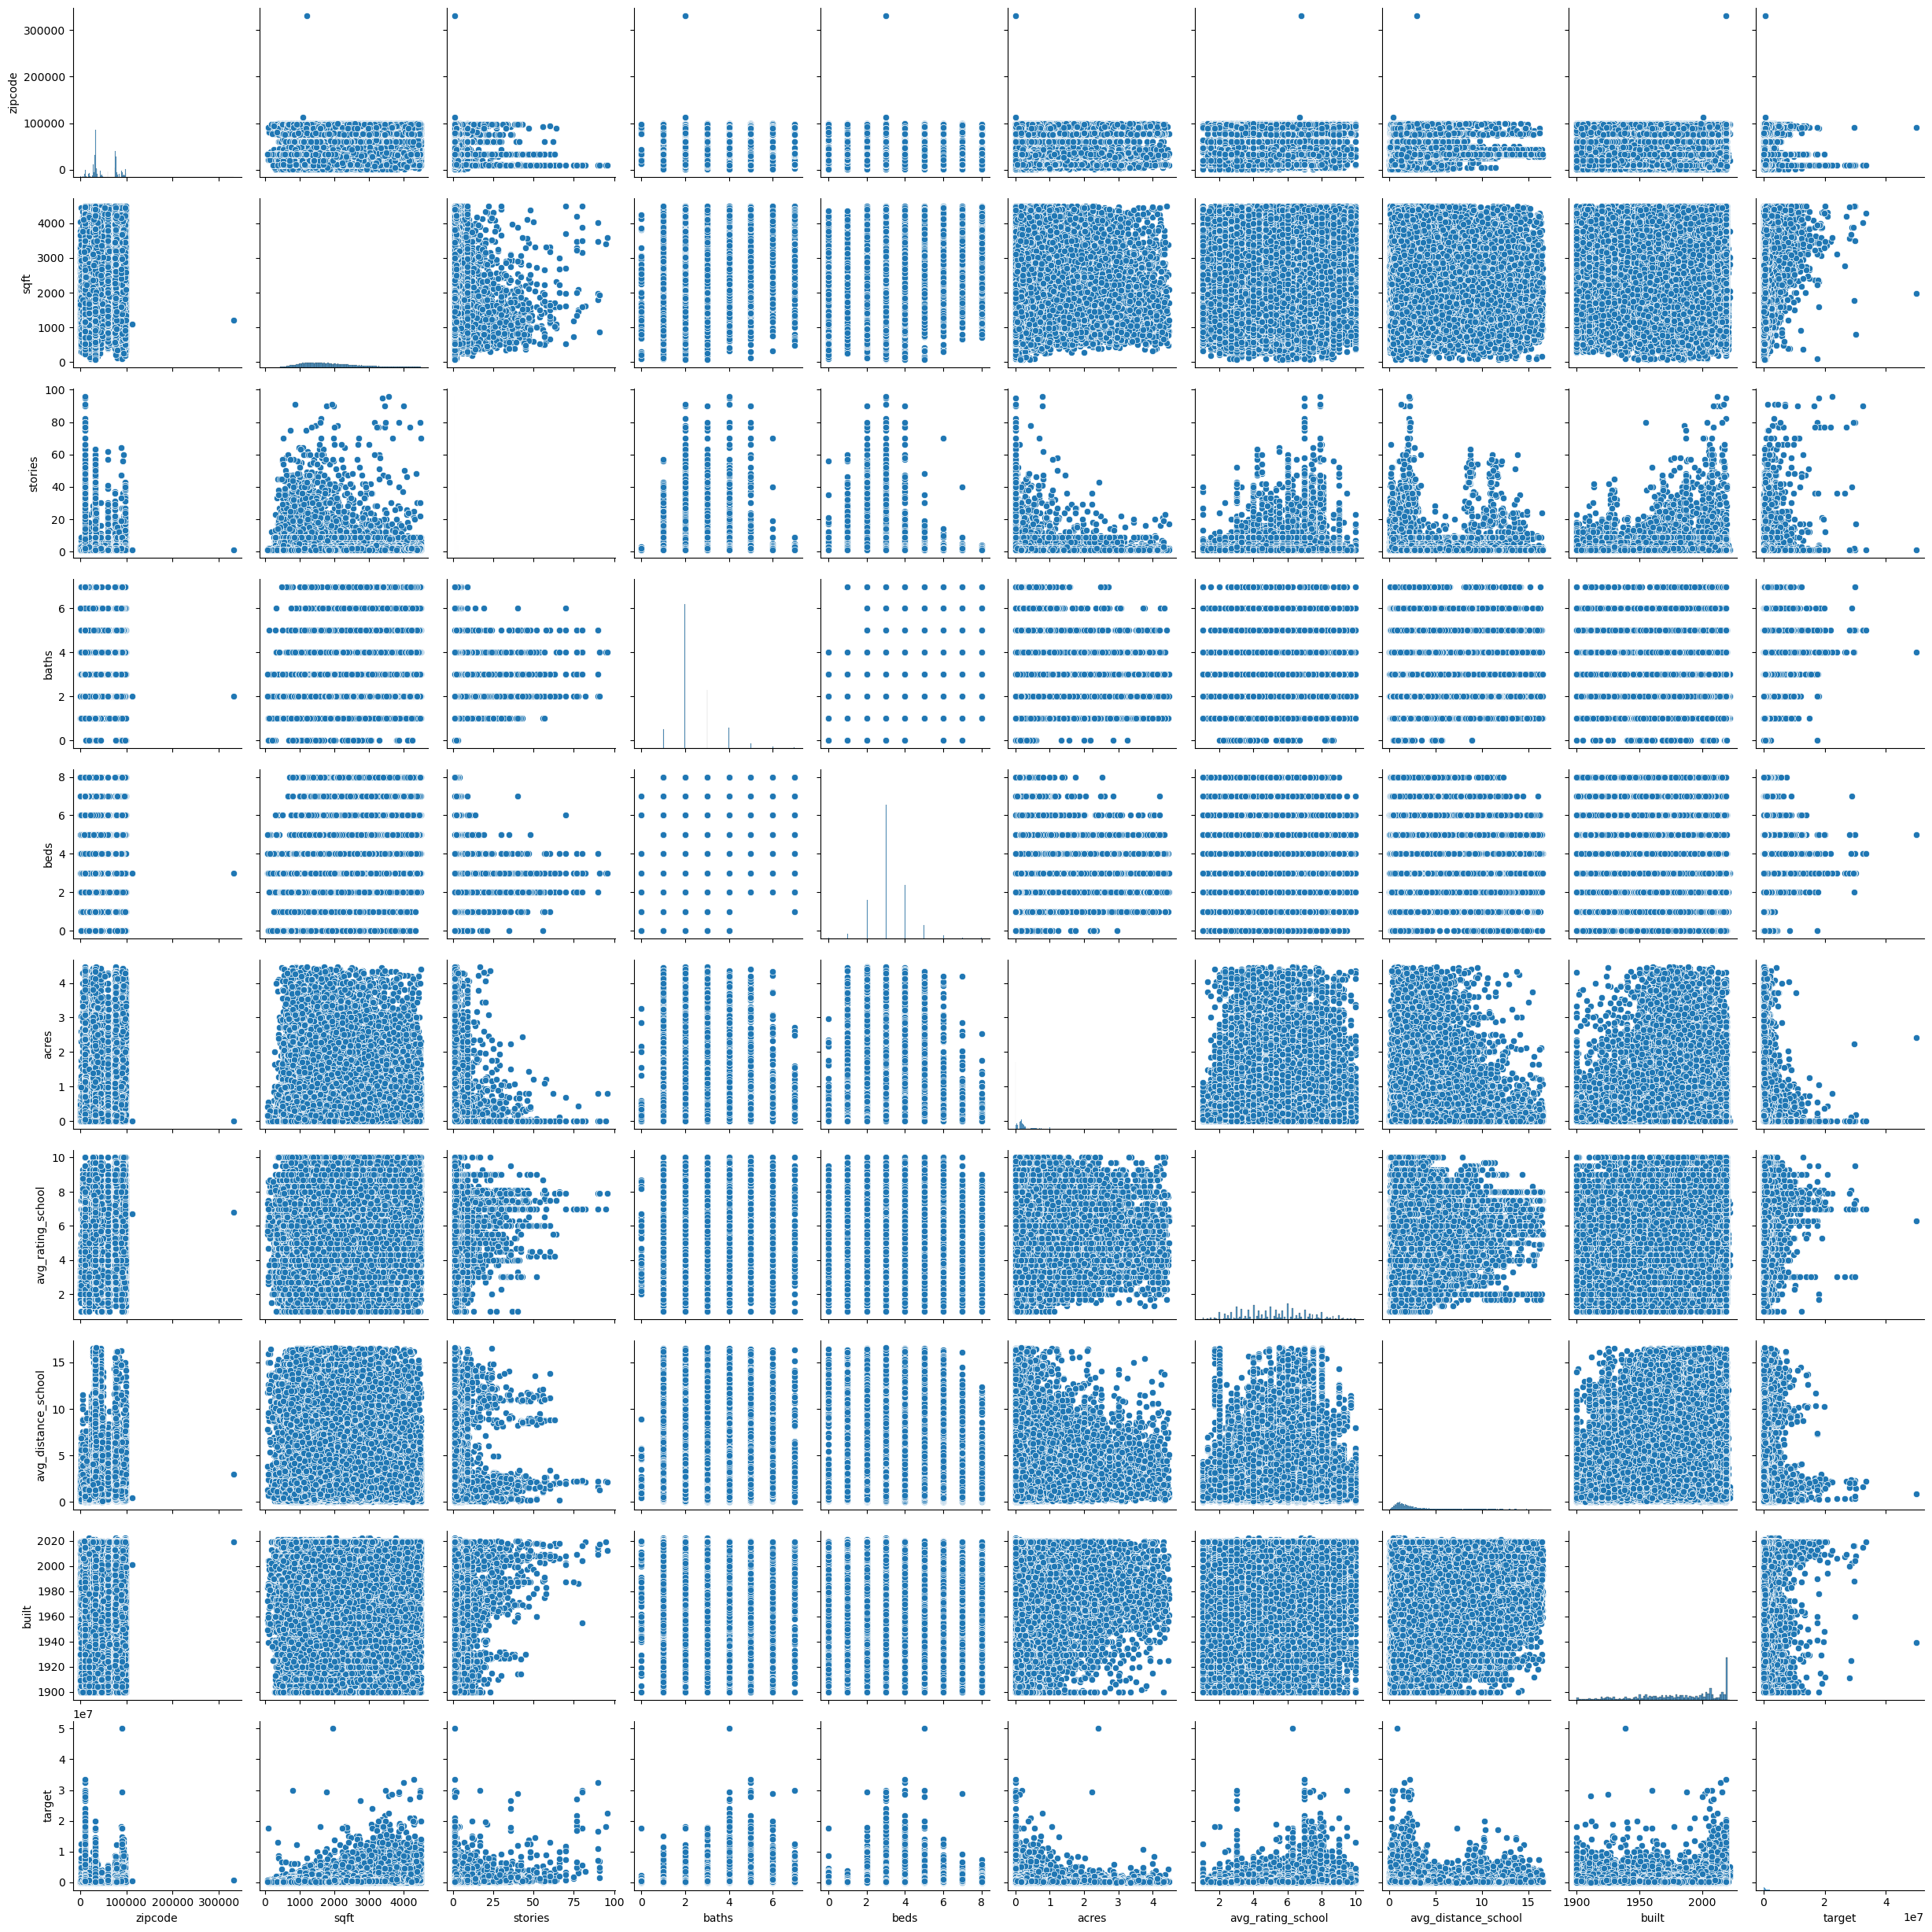

In [8]:
sns.pairplot(data)
plt.show()

Ни один из признаков не имеет Гауссова распределения. Нам понадобится логарифмирование данных. Чтобы наверняка убедиться в этом, выведем распределения числовых признаков: 

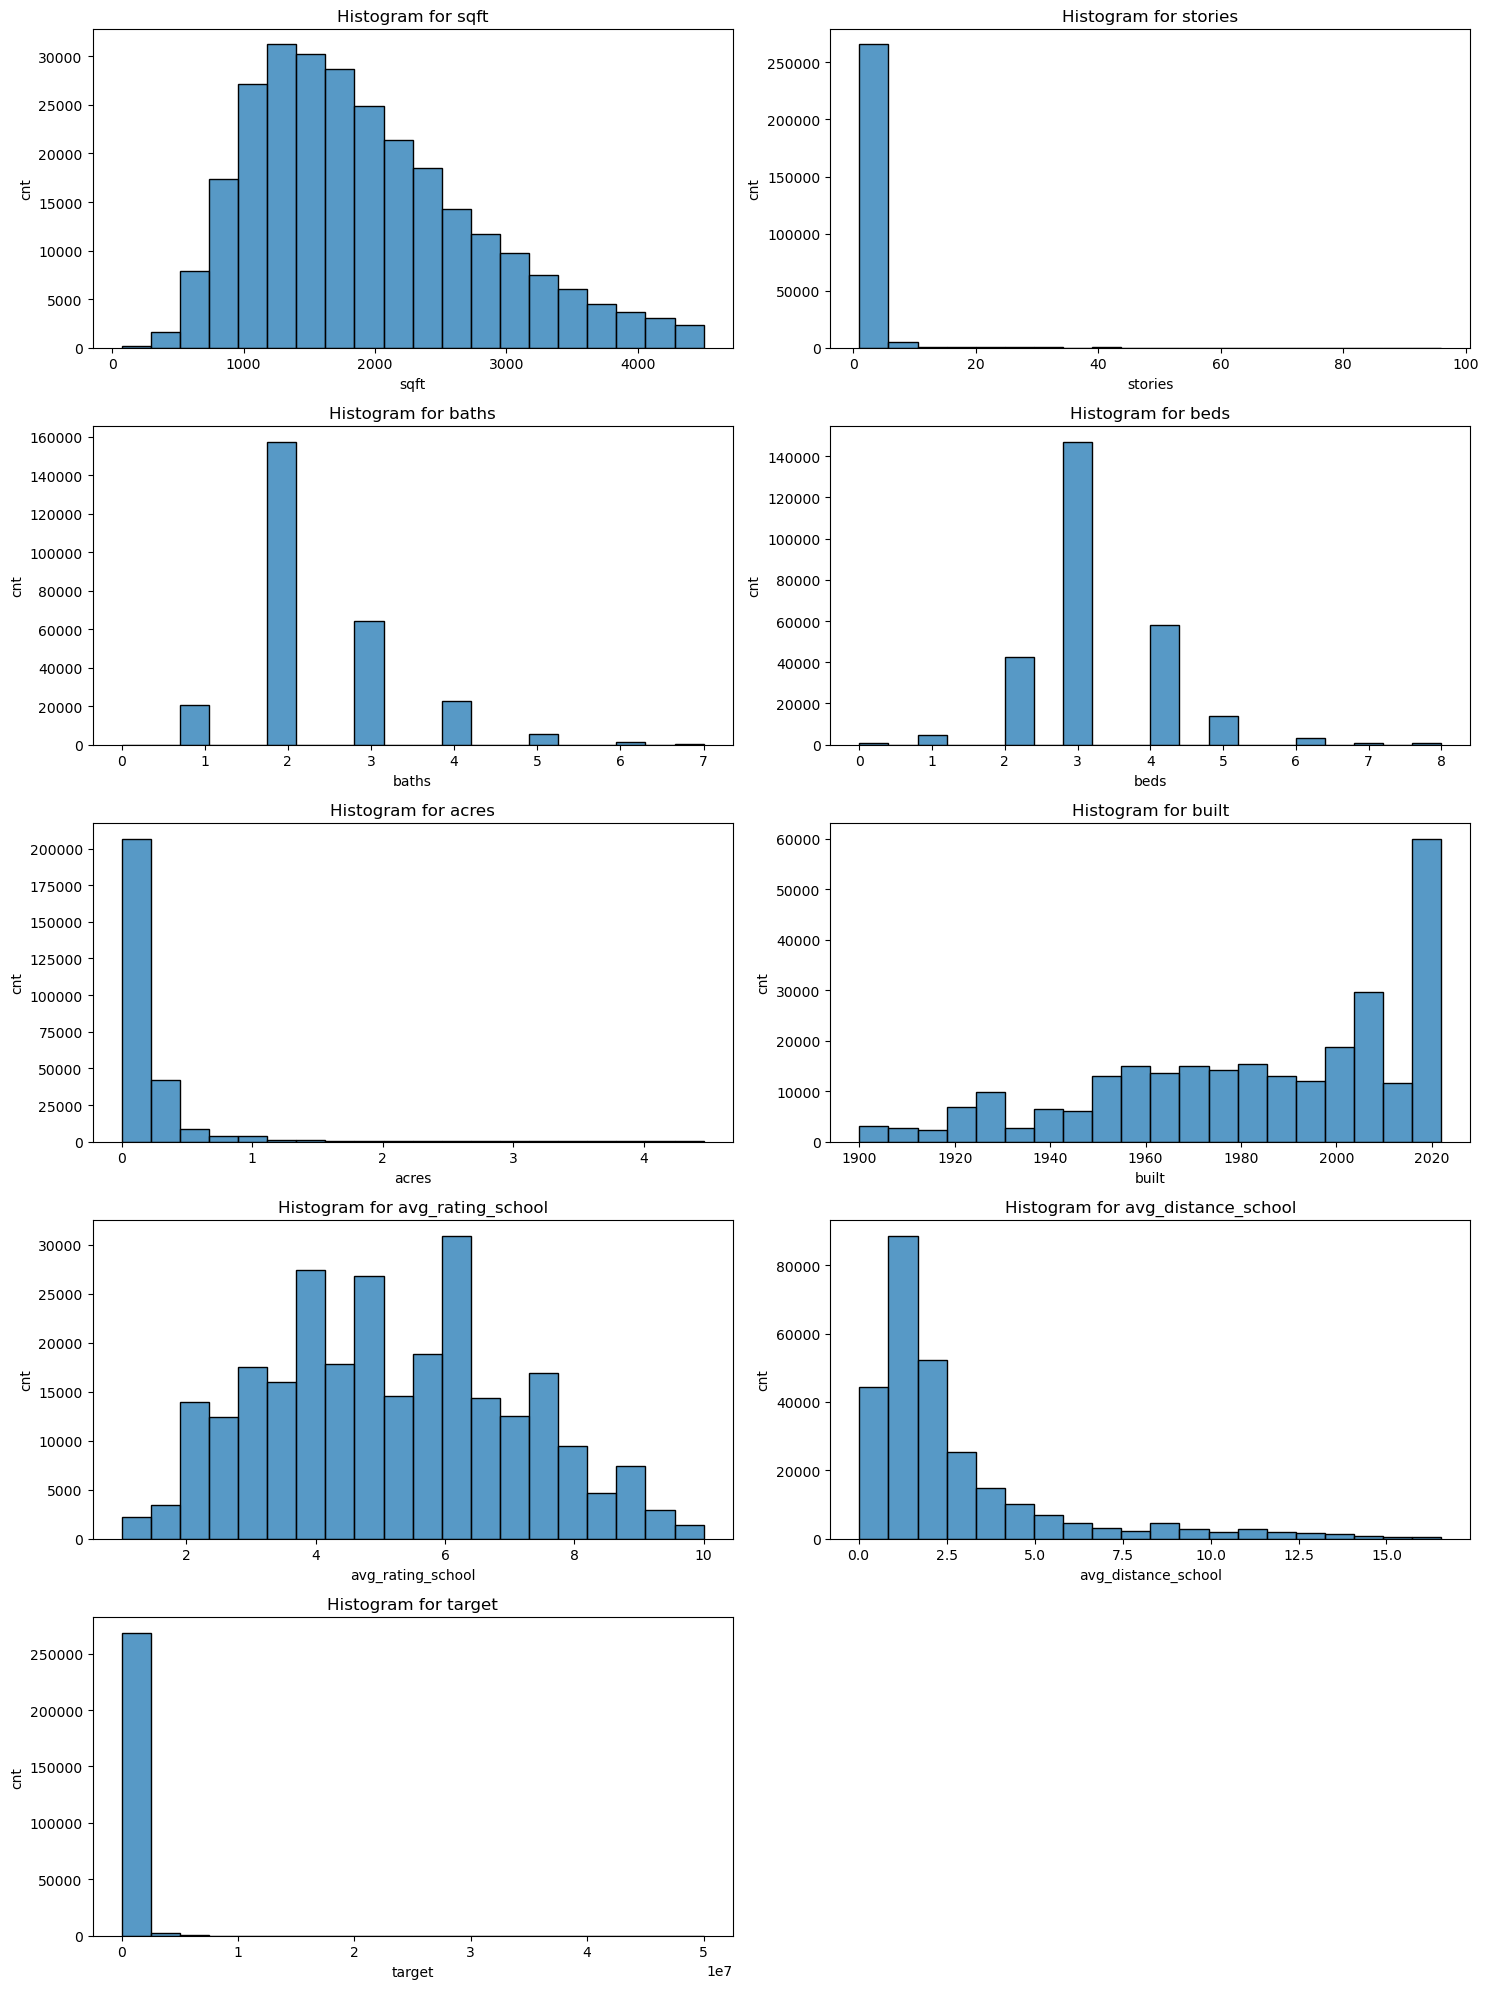

In [9]:
num_features = ['sqft', 'stories', 'baths', 'beds', 
                'acres', 'built', 'avg_rating_school', 
                'avg_distance_school', 'target']

num_plots = len(num_features)
num_rows = (num_plots + 1) // 2 # доп. строка для нечетного числа гистограмм
num_cols = 2

fig, axes = plt.subplots(
    nrows=num_rows, 
    ncols=num_cols, 
    figsize=(15, num_rows*4)
)

for i, feature in enumerate(num_features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    sns.histplot(data[feature], bins=20, ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('cnt')
    ax.set_title(f'Histogram for {feature}')

# удаление неиспользуемых подзаголовков
if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

У некоторых признаков наблюдается распределение, близкое к нормальному. Уточним этот момент, применив статистический тест Колмогорова-Смирнова:

In [10]:
# список исследуемых признаков
features_list = ['sqft', 'baths', 'beds', 'avg_rating_school']

for feature in features_list:
    _, p_value = stats.kstest(data[feature], 'norm')
    alpha = 0.05 # уровень значимости
    
    if p_value < alpha:
        print(f"Признак {feature} не имеет нормальное распределение.")
    else:
        print(f"Признак {feature} имеет нормальное распределение.")

Признак sqft не имеет нормальное распределение.
Признак baths не имеет нормальное распределение.
Признак beds не имеет нормальное распределение.
Признак avg_rating_school не имеет нормальное распределение.


Логарифмируем `target` и далее будем рассматривать логарифм в качестве целевого признака:

In [11]:
log_target = np.log(data['target'])

Поскольку в признаке отсутствуют нулевые значения, прибавление единицы к признаку является излишним.  

Построим гистограмму и боксплот целевого признака в логарифмическом масштабе, а также проверим его распределение с помощью статистического теста Д'Агостино:

P-value = 0.0
Распределение отлично от нормального


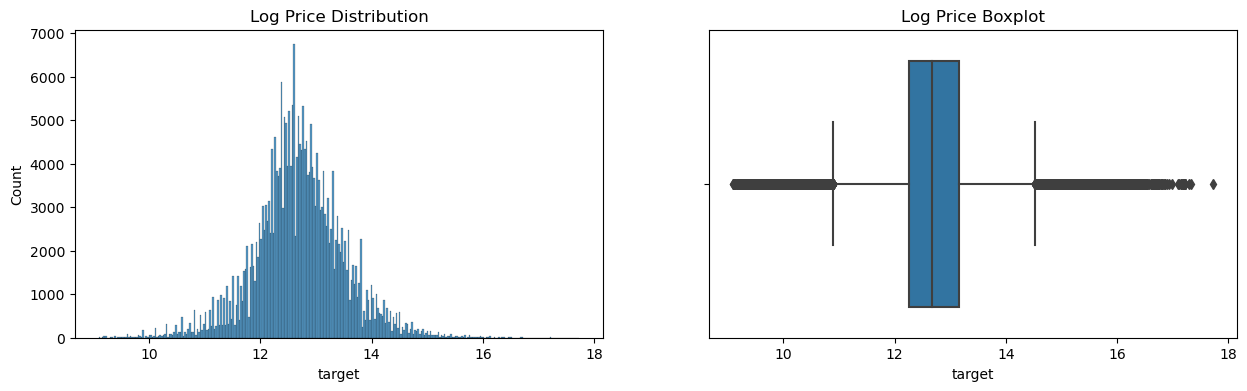

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
histplot = sns.histplot(data = data, x = log_target, ax = axes[0])
histplot.set_title('Log Price Distribution')
boxplot = sns.boxplot(data = data, x = log_target, ax = axes[1])
boxplot.set_title('Log Price Boxplot')

# постановка гипотез
H0 = 'Данные распределены нормально'
Ha = 'Распределение отлично от нормального'

alpha = 0.05 # уровень значимости

_, p = stats.normaltest(log_target)
print(f'P-value = {round(p, 2)}')

if p > alpha / 2:
    print(H0)
else:
    print(Ha)

На гистограмме по-прежнему выражен перекос в правую сторону, однако распределение стало ближе к нормальному.  

Давайте посмотрим, как с течением времени менялись цены на объекты недвижимости:

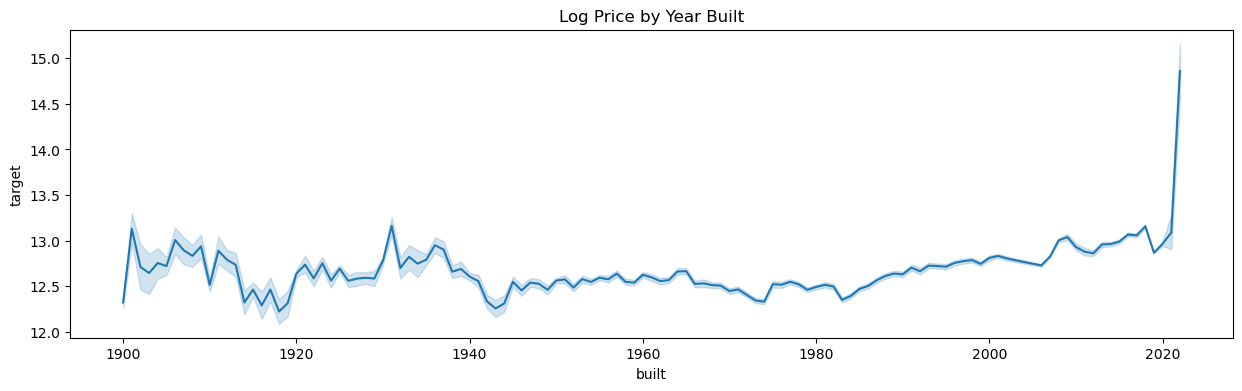

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

built_lineplot = sns.lineplot(
    data=data, 
    x='built', 
    y=log_target, 
    ax=axes)

# подзаголовок
built_lineplot.set_title('Log Price by Year Built')

plt.show()

Цена на недвижимость с учетом инфляции имеет восходящий тренд. Также наблюдается периоды спада, которые затем компенсируются постепенным восстановлением спроса. Если присмотреться, то спады наблюдаются в период окончания Первой мировой (1918-1920 гг.) и начало Второй мировой войн. Бурный рост цен на недвижимость наблюдается в годы Великой депрессии (1929-1933 гг.), а также за последние годы, начиная с 2020. Скорее всего, это связано с усиливающейся инфляцией и турбулентностью экономики страны как предвестников крупных вооруженных конфликтов, свойственных эпохам нестабильности.  

Попробуем поискать зависимость между парами признаков. Посмотрим корреляцию между стоимостью объекта в логарифмическом масштабе и его статусом в базе объектов агентства недвижимости:

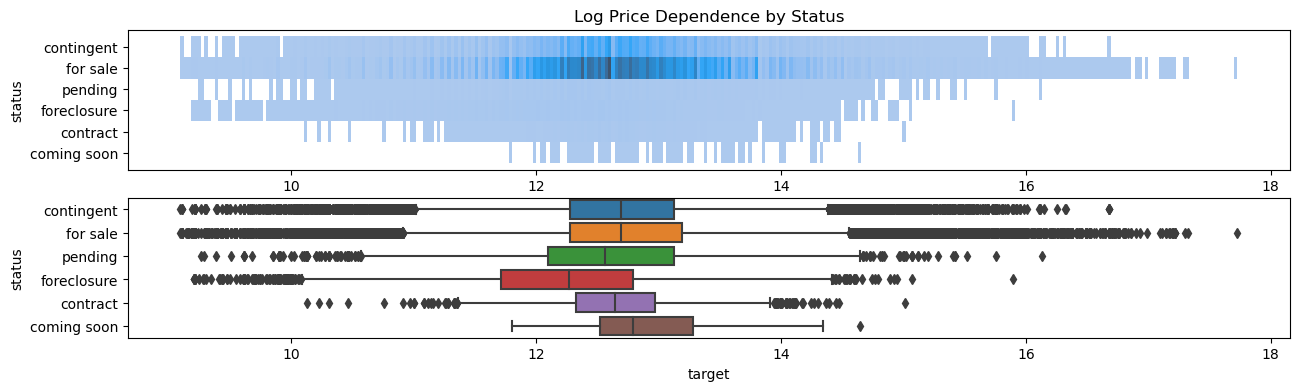

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 4))
histplot = sns.histplot(
    data = data,
    x = log_target,
    y = 'status',
    ax = axes[0]
)

histplot.set_title('Log Price Dependence by Status')
boxplot = sns.boxplot(
    data = data,
    x = log_target,
    y = 'status',
    ax = axes[1]
)

Медианное значение цены выше всего у объектов с предварительным показом - статус `coming soon`. Цена на такие объекты кажется немного завышенной. Это логично, поскольку такие объекты пока что не выставлены на продажу и окончательная цена на них еще не сформирована. Скорее всего, она будет снижаться в рамках маркетинговых акций или действующих программ стимулирования продаж.  

Стоимость объектов со статусом `contingent` и `for sale` практически идентична - это самые многочисленные категории в агентстве недвижимости, которые выставлены на продажу.  

Наименьшую стоимость имеют объекты со статусом `foreclosure`, поскольку эти объекты реализуются в счет погашения долга перед кредиторами, и обе стороны заинтересованы в как можно более быстром закрытии сделки.  

Иными словами, по некоторым статусам распределения отличаются, т.е. признак статуса объекта имеет значении при формировании цены на недвижимость.

Посмотрим, есть ли статистическая значимость для оставшихся категориальных признаков. Для удобства анализа составим список из нужных:

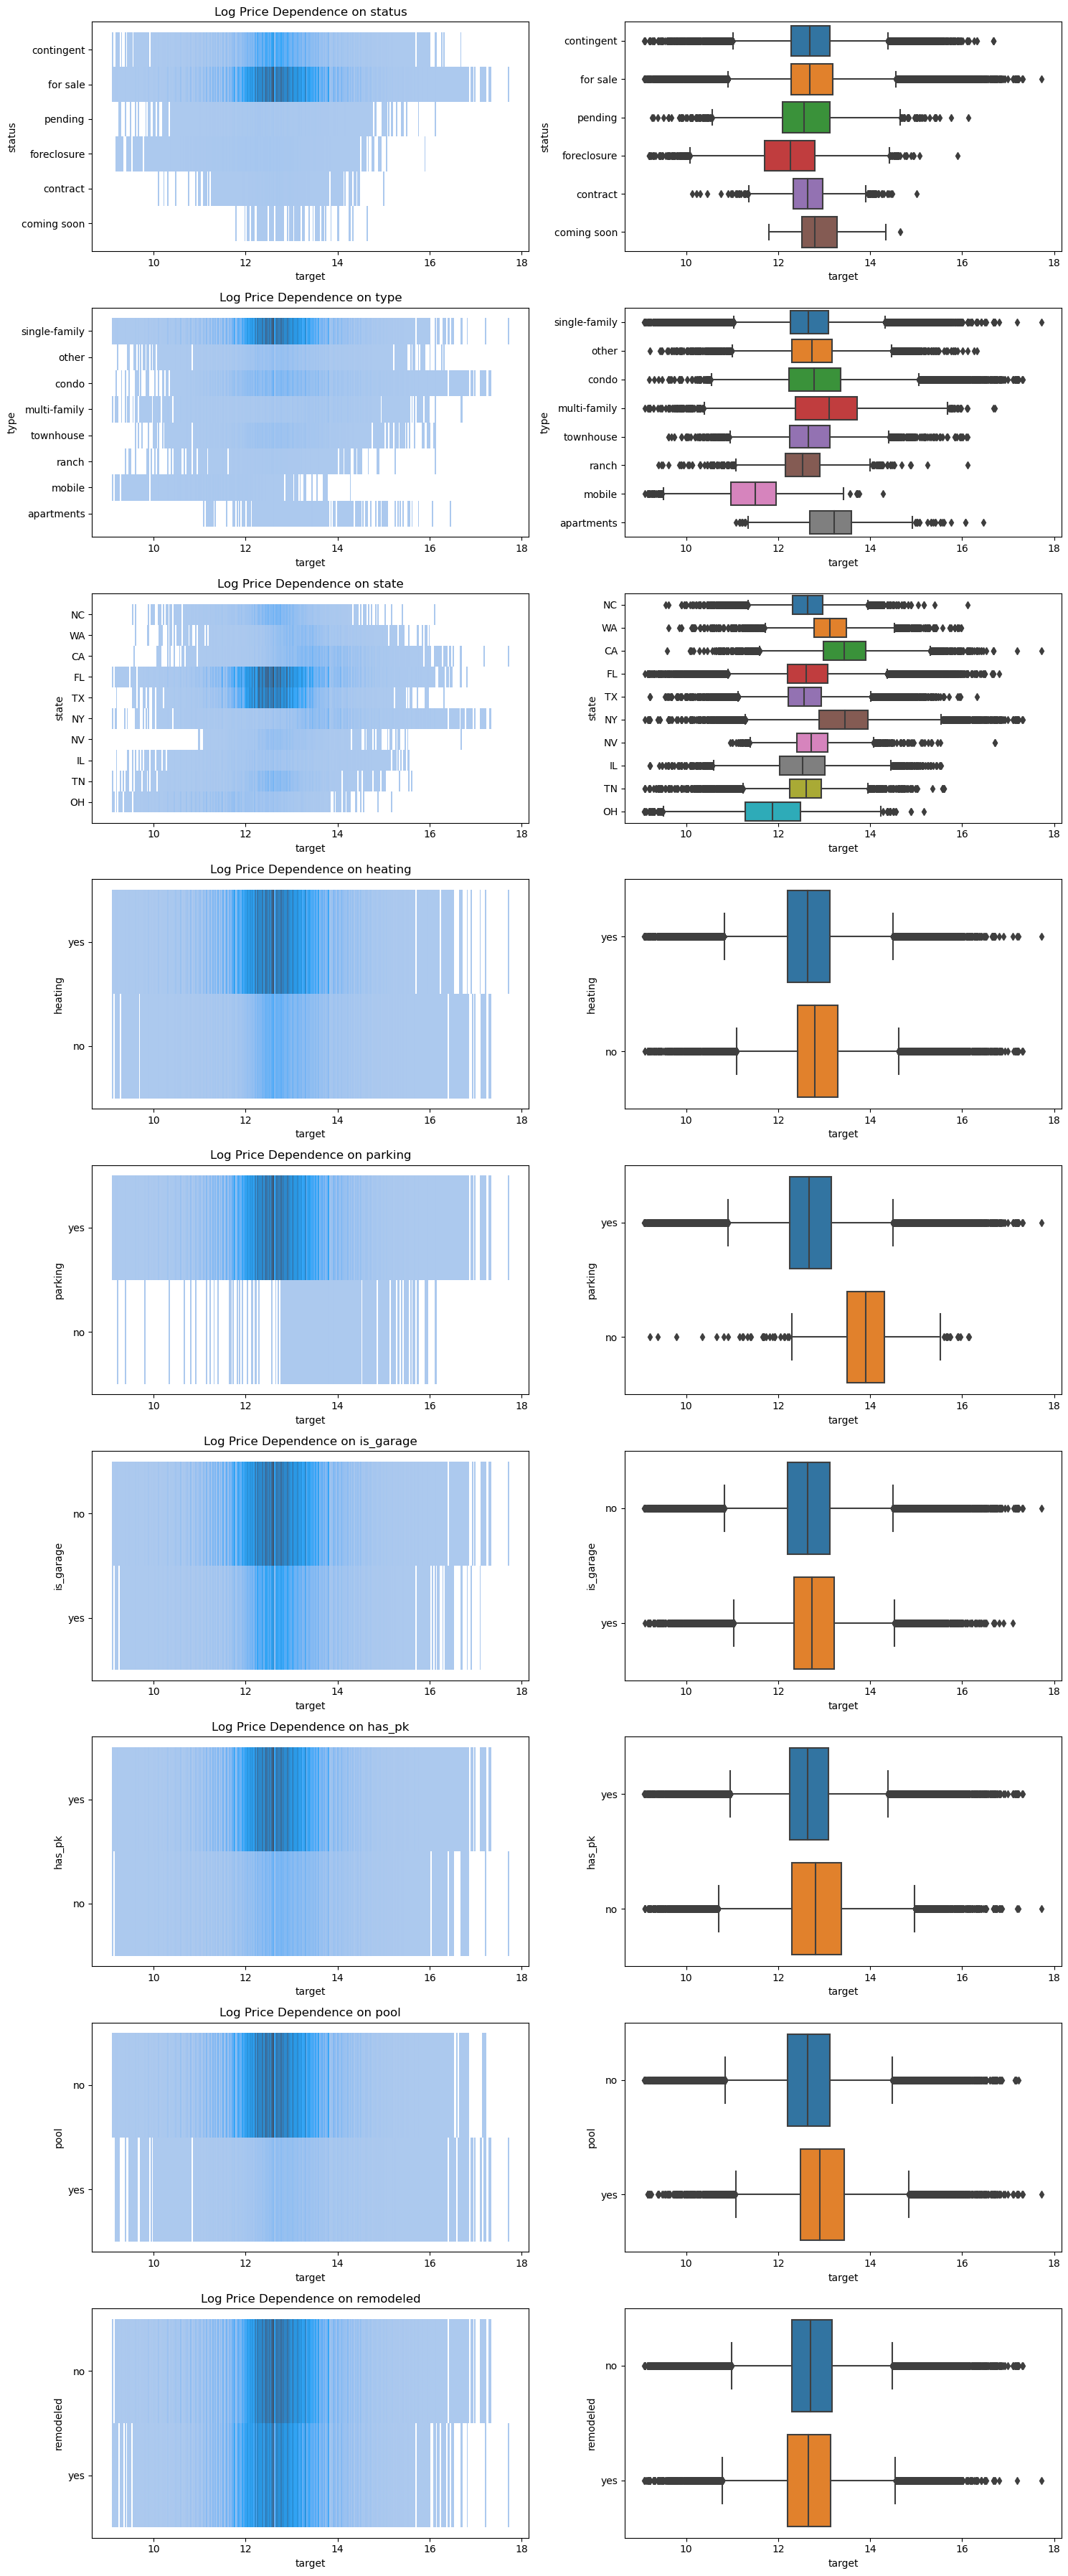

In [15]:
# список оставшихся категориальных признаков

cat_features = ['status', 'type', 'state', 'heating', 
                'parking', 'is_garage', 'has_pk', 
                'pool', 'remodeled']

fig, axes = plt.subplots(
    nrows=len(cat_features), 
    ncols=2, 
    figsize=(15, len(cat_features)*4)
)

for i, feature in enumerate(cat_features):
    top_10_categories = data[feature].value_counts().nlargest(10).index.tolist()  # Вывод топ 10 категорий
    
    histplot = sns.histplot(
        data=data[data[feature].isin(top_10_categories)],  # Фильтрация 
        x=log_target,
        y=feature,
        ax=axes[i, 0]
    )
    histplot.set_title(f'Log Price Dependence on {feature}')
    
    boxplot = sns.boxplot(
        data=data[data[feature].isin(top_10_categories)],  # Фильтрация
        x=log_target,
        y=feature,
        ax=axes[i, 1]
    )

plt.tight_layout()
plt.show()

Все категориальные признаки в большей или меньшей степени влияют на стоимость недвижимости. Что касается признаков наличия собственного гаража для объекта или факта наличия реставрации  - распределения в категориях все же незначительно отличаются, и это не позволяет нам отвергнуть альтернативную гипотезу о влиянии признака на стоимость объекта недвижимости. Докажем это при помощи теста Манна-Уитни на примере признака `is_garage`:

In [16]:
is_garage = data['is_garage'].values

# преобразование категорий к 0 и 1
num_values_yes = (is_garage == "yes").astype(int)
num_values_no = (is_garage == "no").astype(int)

_, p_value = stats.mannwhitneyu(num_values_yes, num_values_no)

if p_value < 0.05:
    print("Существует статистически значимая разница между категориями.")
else:
    print("Нет статистически значимой разницы между категориями.")

Существует статистически значимая разница между категориями.


Посмотрим распределение категорий внутри категориальных признаков при помощи гистограмм:

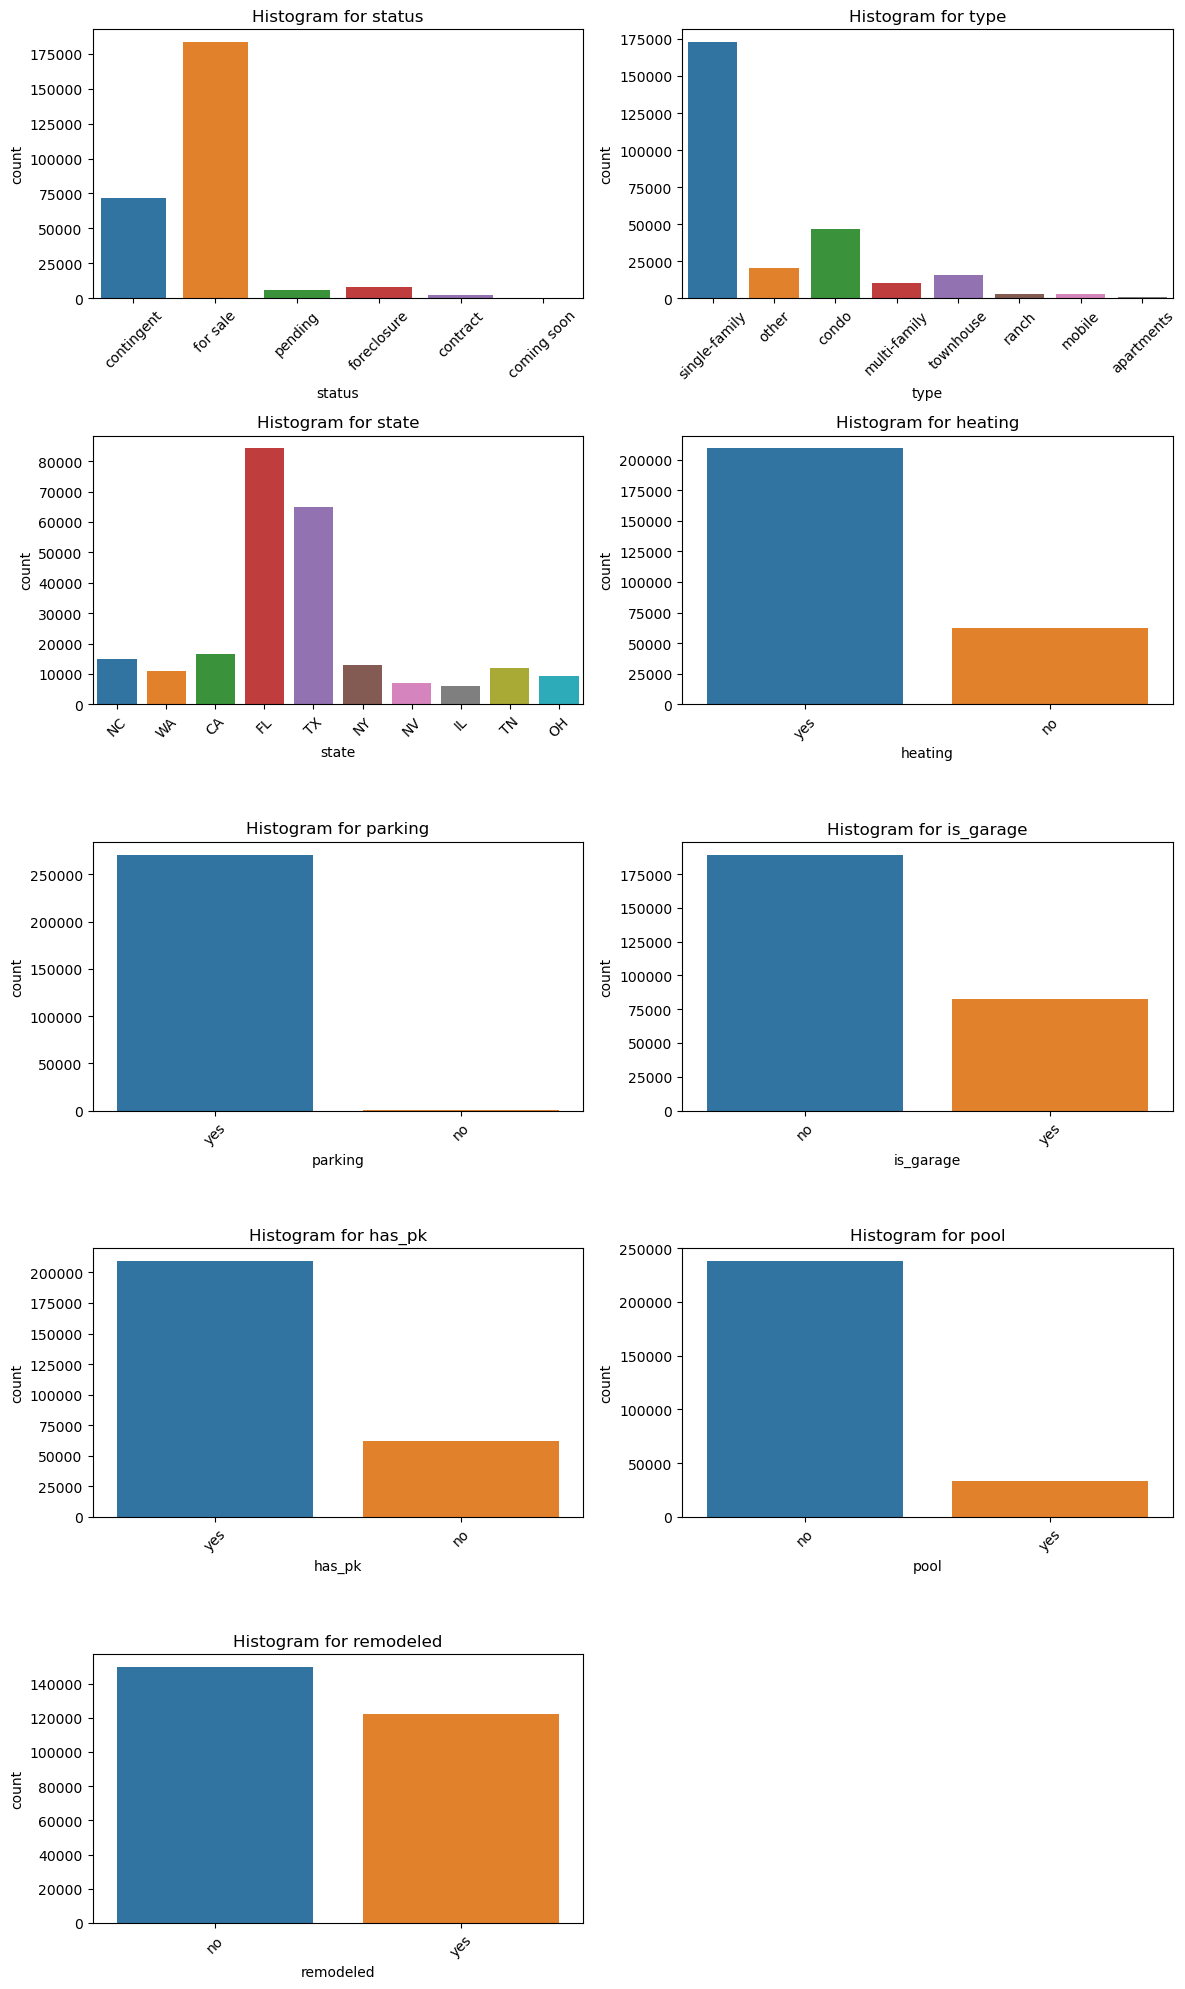

In [17]:
num_plots = len(cat_features)
num_rows = (num_plots + 1) // 2
num_cols = 2

fig, axes = plt.subplots(
    nrows=num_rows, 
    ncols=num_cols, 
    figsize=(12, num_rows*4)
)

for i, feature in enumerate(cat_features):
    row = i // num_cols
    col = i % num_cols
    
    top_10_categories = data[feature].value_counts().nlargest(10).index.tolist()
    axes[row, col].set_title(f"Histogram for {feature}")
    sns.countplot(
        data=data[data[feature].isin(top_10_categories)], 
        x=feature, 
        ax=axes[row, col])
    
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)

if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Рассмотрим более детально, в каких штатах находится самая дорогая недвижимость в разрезе медианной стоимости объекта:

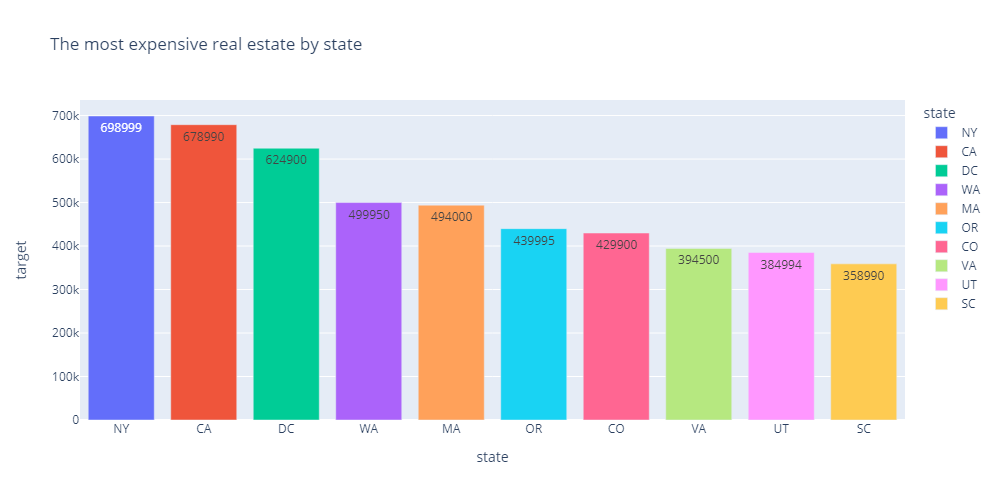

In [18]:
# топ 10 штатов по самой дорогой недвижимости
state_data = data.groupby(
    by='state', 
    as_index=False
)[['target']].median().round(0).nlargest(10, columns=['target'])

fig = px.bar(
    data_frame=state_data, 
    x='state', 
    y='target', 
    color='state', # расцветка по штатам
    text='target', 
    orientation='v', 
    height=500, 
    width=1000, 
    title='The most expensive real estate by state'
)

fig.show()

Лидером по стоимости недвижимости является Нью-Йорк, следом идут респектабельная Калифорния и административный Вашингтон, округ Колумбия. Достаточно высокую стоимость имеют объекты в Массачусетсе - сказывается концентрация топовых учебных заведений, таких как Harvard и MIT.  

Посмотрим, где предложений о покупке объектов больше всего:

In [19]:
# группировка количества объектов в разрезе штата
cnt_by_states = data.groupby('state').size().reset_index(name='count')

fig = px.choropleth(cnt_by_states, 
                    locations='state', 
                    locationmode='USA-states', 
                    color='count',
                    color_continuous_scale='Greens', # цветовая шкала
                    scope='usa',
                    title='Concentration of real estate by state')

fig.show()

Подавляющее большинство объектов сконцентрировано в штатах Флорида и Техас, есть также предложения обосноваться на востоке или на западе страны. Объектов в центральных штатах очень мало - они не пользуются популярностью, соответственно и предложений по ним практически нет. Возможно, спрос на южные штаты обусловлен привлекательной стоимостью? Давайте проверим данную гипотезу: 

In [20]:
state_data = data.groupby(
    by='state', 
    as_index=False
)[['target']].median().round(0)

print(f"Мин. медианная цена объекта: ${state_data['target'].min():,.0f}")

print(f"Макс. медианная цена объекта: ${state_data['target'].max():,.0f}")

print(f"Медианная цена объекта в штате Флорида: $\
{state_data.loc[state_data['state'] == 'FL', 'target'].values[0]:,.0f}")

print(f"Медианная цена объекта в штате Техас: $\
{state_data.loc[state_data['state'] == 'TX', 'target'].values[0]:,.0f}")

Мин. медианная цена объекта: $92,500
Макс. медианная цена объекта: $698,999
Медианная цена объекта в штате Флорида: $299,500
Медианная цена объекта в штате Техас: $285,000


Действительно, цены на объекты по рассматриваемым штатам весьма демократичные. Медианная цена ниже среднего, отсюда повышенные спрос и предложение на такую недвижимость. Гипотеза подтверждена.  

Выявим штат с самой дешевой недвижимостью:

In [21]:
min_index = state_data['target'].idxmin()
state_with_min_target = state_data.loc[min_index, 'state']
print(f"Самая дешевая недвижимость в штате: {state_with_min_target}")

Самая дешевая недвижимость в штате: MI


Менее всего котируется недвижимость на севере страны в штате Мичиган.  

Для какого типа объектов медианная стоимость выше в зависимости от этажности? Исследуем вопрос, построив соответствующую диаграмму рассеяния:

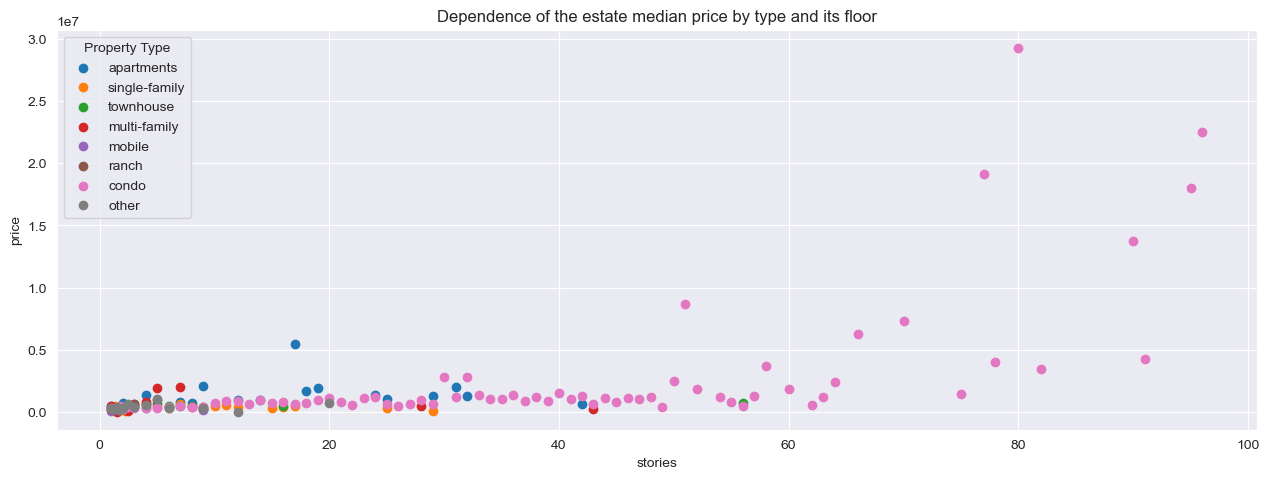

In [22]:
apartments_df = data[data['type'] == 'apartments']
single_df = data[data['type'] == 'single-family']
townhouse_df = data[data['type'] == 'townhouse']
multi_df = data[data['type'] == 'multi-family']
mobile_df = data[data['type'] == 'mobile']
ranch_df = data[data['type'] == 'ranch']
condo_df = data[data['type'] == 'condo']
other_df = data[data['type'] == 'other']

sns.set_style('darkgrid')
fig = plt.figure(figsize=(12, 4))
axes = fig.add_axes([0, 0, 1, 1])

axes.scatter(
    apartments_df.groupby('stories')['target'].median().index, 
    apartments_df.groupby('stories')['target'].median().values, 
    label='apartments'
)
axes.scatter(
    single_df.groupby('stories')['target'].median().index, 
    single_df.groupby('stories')['target'].median().values,
    label='single-family'
)
axes.scatter(
    townhouse_df.groupby('stories')['target'].median().index, 
    townhouse_df.groupby('stories')['target'].median().values,
    label='townhouse'
)
axes.scatter(
    multi_df.groupby('stories')['target'].median().index, 
    multi_df.groupby('stories')['target'].median().values,
    label='multi-family'
)
axes.scatter(
    mobile_df.groupby('stories')['target'].median().index, 
    mobile_df.groupby('stories')['target'].median().values,
    label='mobile'
)
axes.scatter(
    ranch_df.groupby('stories')['target'].median().index, 
    ranch_df.groupby('stories')['target'].median().values,
    label='ranch'
)
axes.scatter(
    condo_df.groupby('stories')['target'].median().index, 
    condo_df.groupby('stories')['target'].median().values,
    label='condo'
)
axes.scatter(
    other_df.groupby('stories')['target'].median().index, 
    other_df.groupby('stories')['target'].median().values,
    label='other'
)

# подписи графика и осей
axes.set_title('Dependence of the estate median price by type and its floor')
axes.set_xlabel('stories')
axes.set_ylabel('price')
axes.legend(title='Property Type')
plt.show()

Медианная цена для всех типов объектов малой и средней этажности практически не меняется, однако для высотных зданий выше 60 этажей цена резко возрастает. Любопытно, что все объекты с повышенной стоимостью - это кондоминиумы, расположенные в крупных городах и мегаполисах, таких как Нью-Йорк, где стоимость за квадратный фут, как правило, выше среднего.